# Part One - Project Based - Neural Network Regressor

**DOMAIN**: Electronics and Telecommunication

**CONTEXT**: A communications equipment manufacturing company has a product which is responsible for emitting informative signals. Company wants to build a 
machine learning model which can help the company to predict the equipment’s signal quality using various parameters. 

**DATA DESCRIPTION**: The data set contains information on various signal tests performed:
1. `Parameters`: Various measurable signal parameters.
2. `Signal_Quality`: Final signal strength or quality


## Import the necessary libraries

In [1]:
import numpy as np # mathematical manipulations
import pandas as pd # data manipulations

# for visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# splitting into train and test sets
from sklearn.model_selection import train_test_split

# Neural Network libraries
import tensorflow as tf

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# initialize random number generator
import random
# set the seed for consistent results for multiple runs
seed = 7
np.random.seed(seed)

## Importing the data

In [2]:
# importing data to a data frame from csv
signals = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Part- 1 - Signal.csv')
# checking top five rows to see if data is imported
signals.head()

,Parameter 1,Parameter 2,Parameter 3,Parameter 4,Parameter 5,Parameter 6,Parameter 7,Parameter 8,Parameter 9,Parameter 10,Parameter 11,Signal_Strength
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Data Analysis and Visualisation

In [3]:
# analysing the shape of data
signals.shape

(1599, 12)

In [4]:
# seeing shape and data types of various features
signals.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Parameter 1      1599 non-null   float64
 1   Parameter 2      1599 non-null   float64
 2   Parameter 3      1599 non-null   float64
 3   Parameter 4      1599 non-null   float64
 4   Parameter 5      1599 non-null   float64
 5   Parameter 6      1599 non-null   float64
 6   Parameter 7      1599 non-null   float64
 7   Parameter 8      1599 non-null   float64
 8   Parameter 9      1599 non-null   float64
 9   Parameter 10     1599 non-null   float64
 10  Parameter 11     1599 non-null   float64
 11  Signal_Strength  1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
# checking null values
signals.isnull().sum()

Parameter 1        0
Parameter 2        0
Parameter 3        0
Parameter 4        0
Parameter 5        0
Parameter 6        0
Parameter 7        0
Parameter 8        0
Parameter 9        0
Parameter 10       0
Parameter 11       0
Signal_Strength    0
dtype: int64

### Observations:
- The dataset contains **1599 data points**, **11 predictors** and **1 target feature**.
- There are no **null** or bad values in the data frame that do not correspond to the data type.
- All the features and target are **numeric** data type.

In [6]:
# 5-point summary and other statistical features of all features
signals.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
Parameter 1,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
Parameter 2,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
Parameter 3,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
Parameter 4,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
Parameter 5,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
Parameter 6,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
Parameter 7,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
Parameter 8,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
Parameter 9,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
Parameter 10,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [7]:
def calculateLowerAndUpperFence(df,col_name):
  '''
  This function calculates the lower and upper fence of a
  feature of a data frame.
  '''
  Q1 = np.percentile(a=df[col_name],q=25) # 25th percentile
  Q3 = np.percentile(a=df[col_name],q=75) # 75th percentile
  IQR = Q3 - Q1 # inter-quartile-range
  cut_off = 1.5 * IQR
  # limit for outliers
  lower_fence = Q1 - cut_off
  upper_fence = Q3 + cut_off
  return lower_fence,upper_fence

In [8]:
def number_of_outliers(df,col_name,lower_fence,upper_fence):
  '''
  This function calculates the number of data points that
  lie beyond the lower and upper fences.
  '''
  outliers = np.where((df[col_name] < lower_fence) | (df[col_name] > upper_fence))
  number_of_outliers = len(outliers[0])
  return number_of_outliers

In [9]:
def plotHistogramAndBoxPlotWithOutliers(df,col_name, outlier_col):
  '''
  This function is used to plot the Histogram of feature with Kernel Density Estimate
  and also the box-plot with outliers.
  '''
  # initialising subplots
  figure, ax = plt.subplots(nrows=1, ncols=2)

  # setting figure parameters
  figure.set_figheight(5)
  figure.set_figwidth(15)

  #setting axes titles
  ax[0].set_title(f'Distribution plot of {col_name.upper()}')
  ax[1].set_title(f'Box plot of {col_name.upper()}')

  # plotting the distribution
  sns.histplot(data=df[col_name],ax=ax[0],kde=True,color='g')
  sns.boxplot(x=df[col_name],ax=ax[1])

  plt.show()

  # figuring upper and lower limits
  lower_fence,upper_fence = calculateLowerAndUpperFence(df,col_name)

  # logical selection of outliers
  no_of_outliers = number_of_outliers(df,col_name,lower_fence,upper_fence)
  if no_of_outliers > 0:
      outlier_col.append(col_name)
      print(f'The number of outliers for {col_name} are {no_of_outliers}')

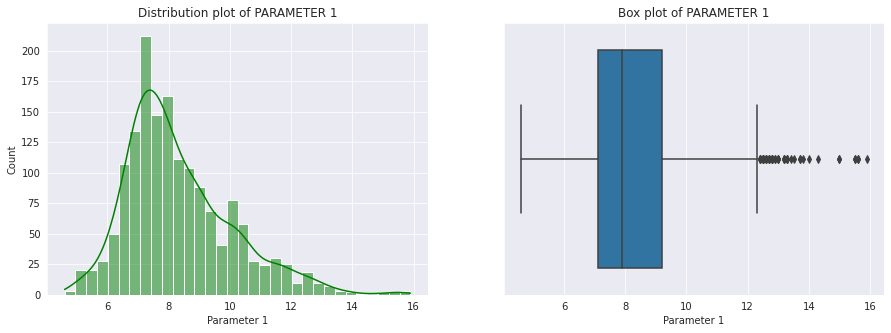

The number of outliers for Parameter 1 are 49
****************************************


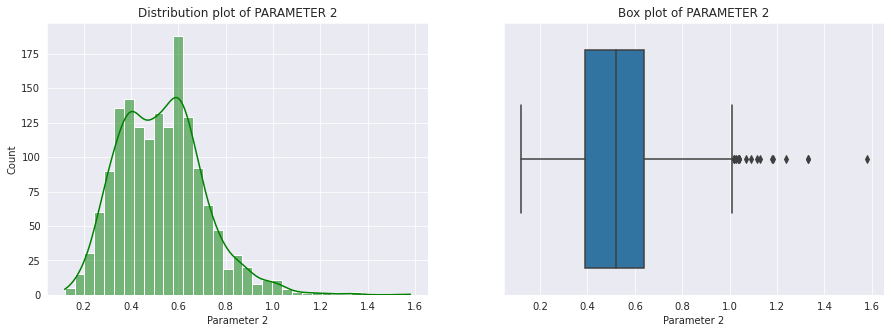

The number of outliers for Parameter 2 are 19
****************************************


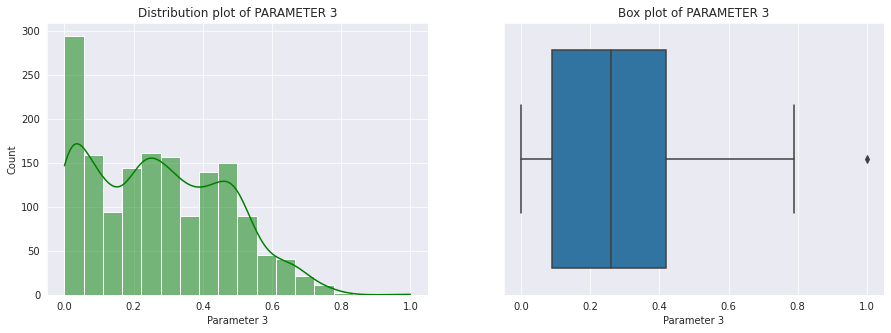

The number of outliers for Parameter 3 are 1
****************************************


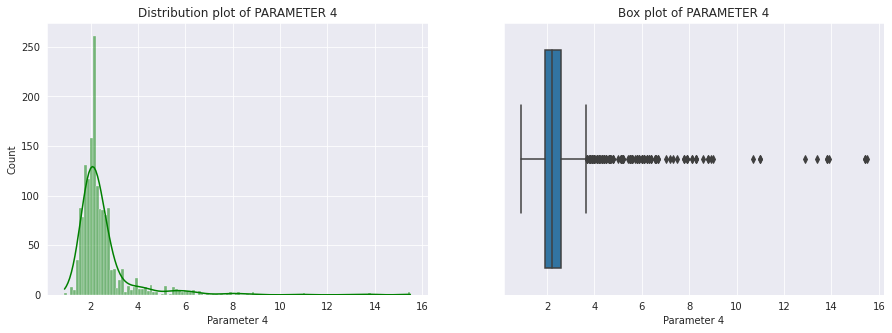

The number of outliers for Parameter 4 are 155
****************************************


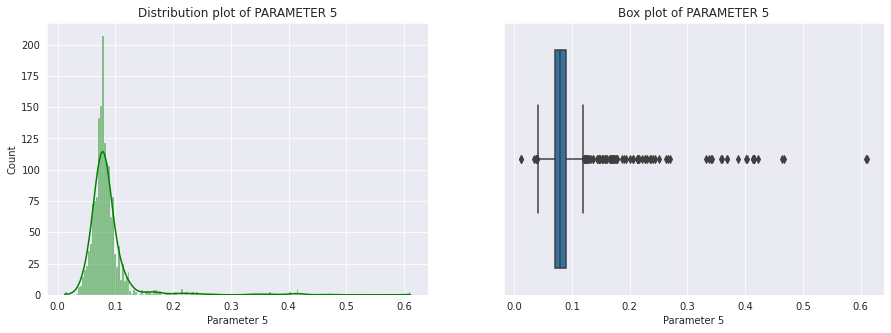

The number of outliers for Parameter 5 are 112
****************************************


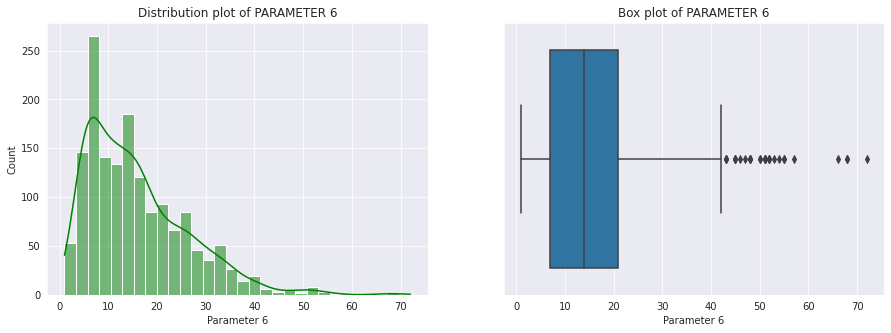

The number of outliers for Parameter 6 are 30
****************************************


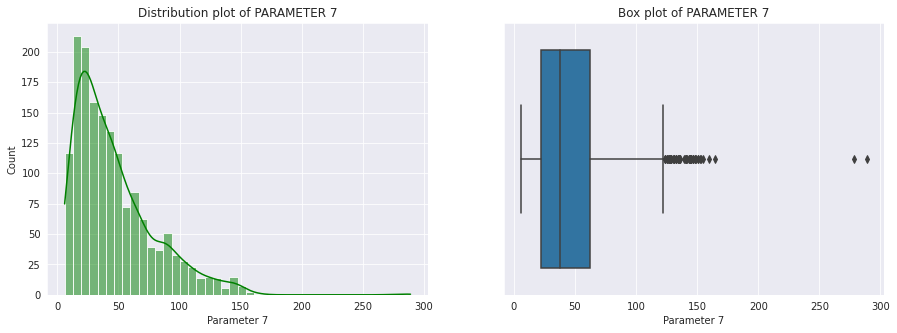

The number of outliers for Parameter 7 are 55
****************************************


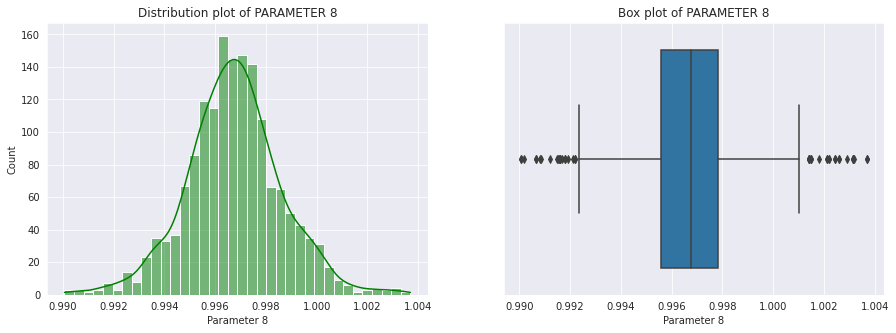

The number of outliers for Parameter 8 are 45
****************************************


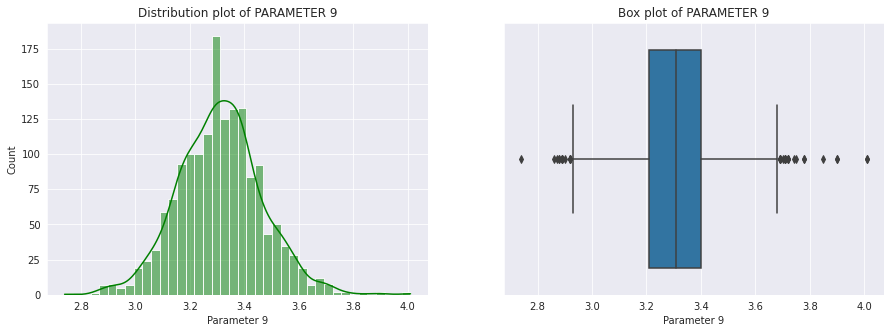

The number of outliers for Parameter 9 are 35
****************************************


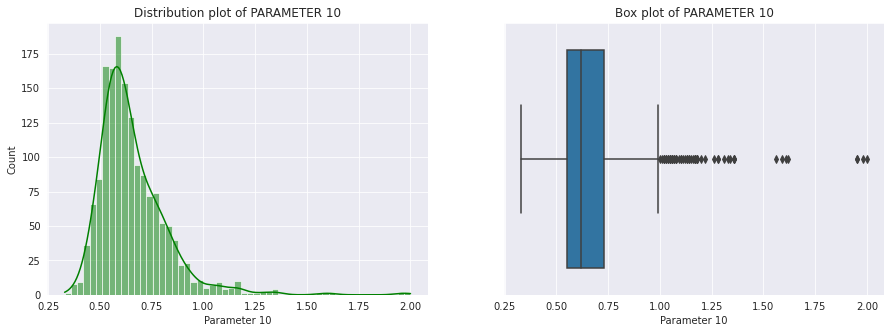

The number of outliers for Parameter 10 are 59
****************************************


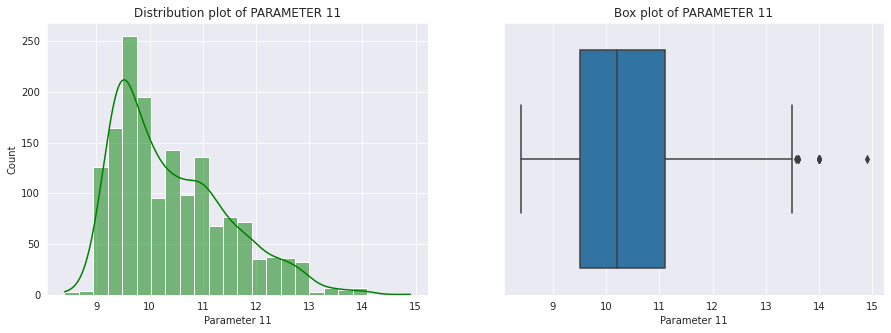

The number of outliers for Parameter 11 are 13
****************************************


In [10]:
outlier_cols = [] # initialising list to hold outlier columns
for col in signals.columns:
  if col != 'Signal_Strength': # excluding target column
    plotHistogramAndBoxPlotWithOutliers(signals,col,outlier_cols) # call to appropriate function
    print('*'*40)

### Observations:
From `describe()` and the visual analysis we could observe:

- The **5-point** summary of all numeric features.
- The scale of the features is highly varied, thus will require **normalization**.
- The distribution of some parameters is **skewed**.
- There are few **outliers** in some features.

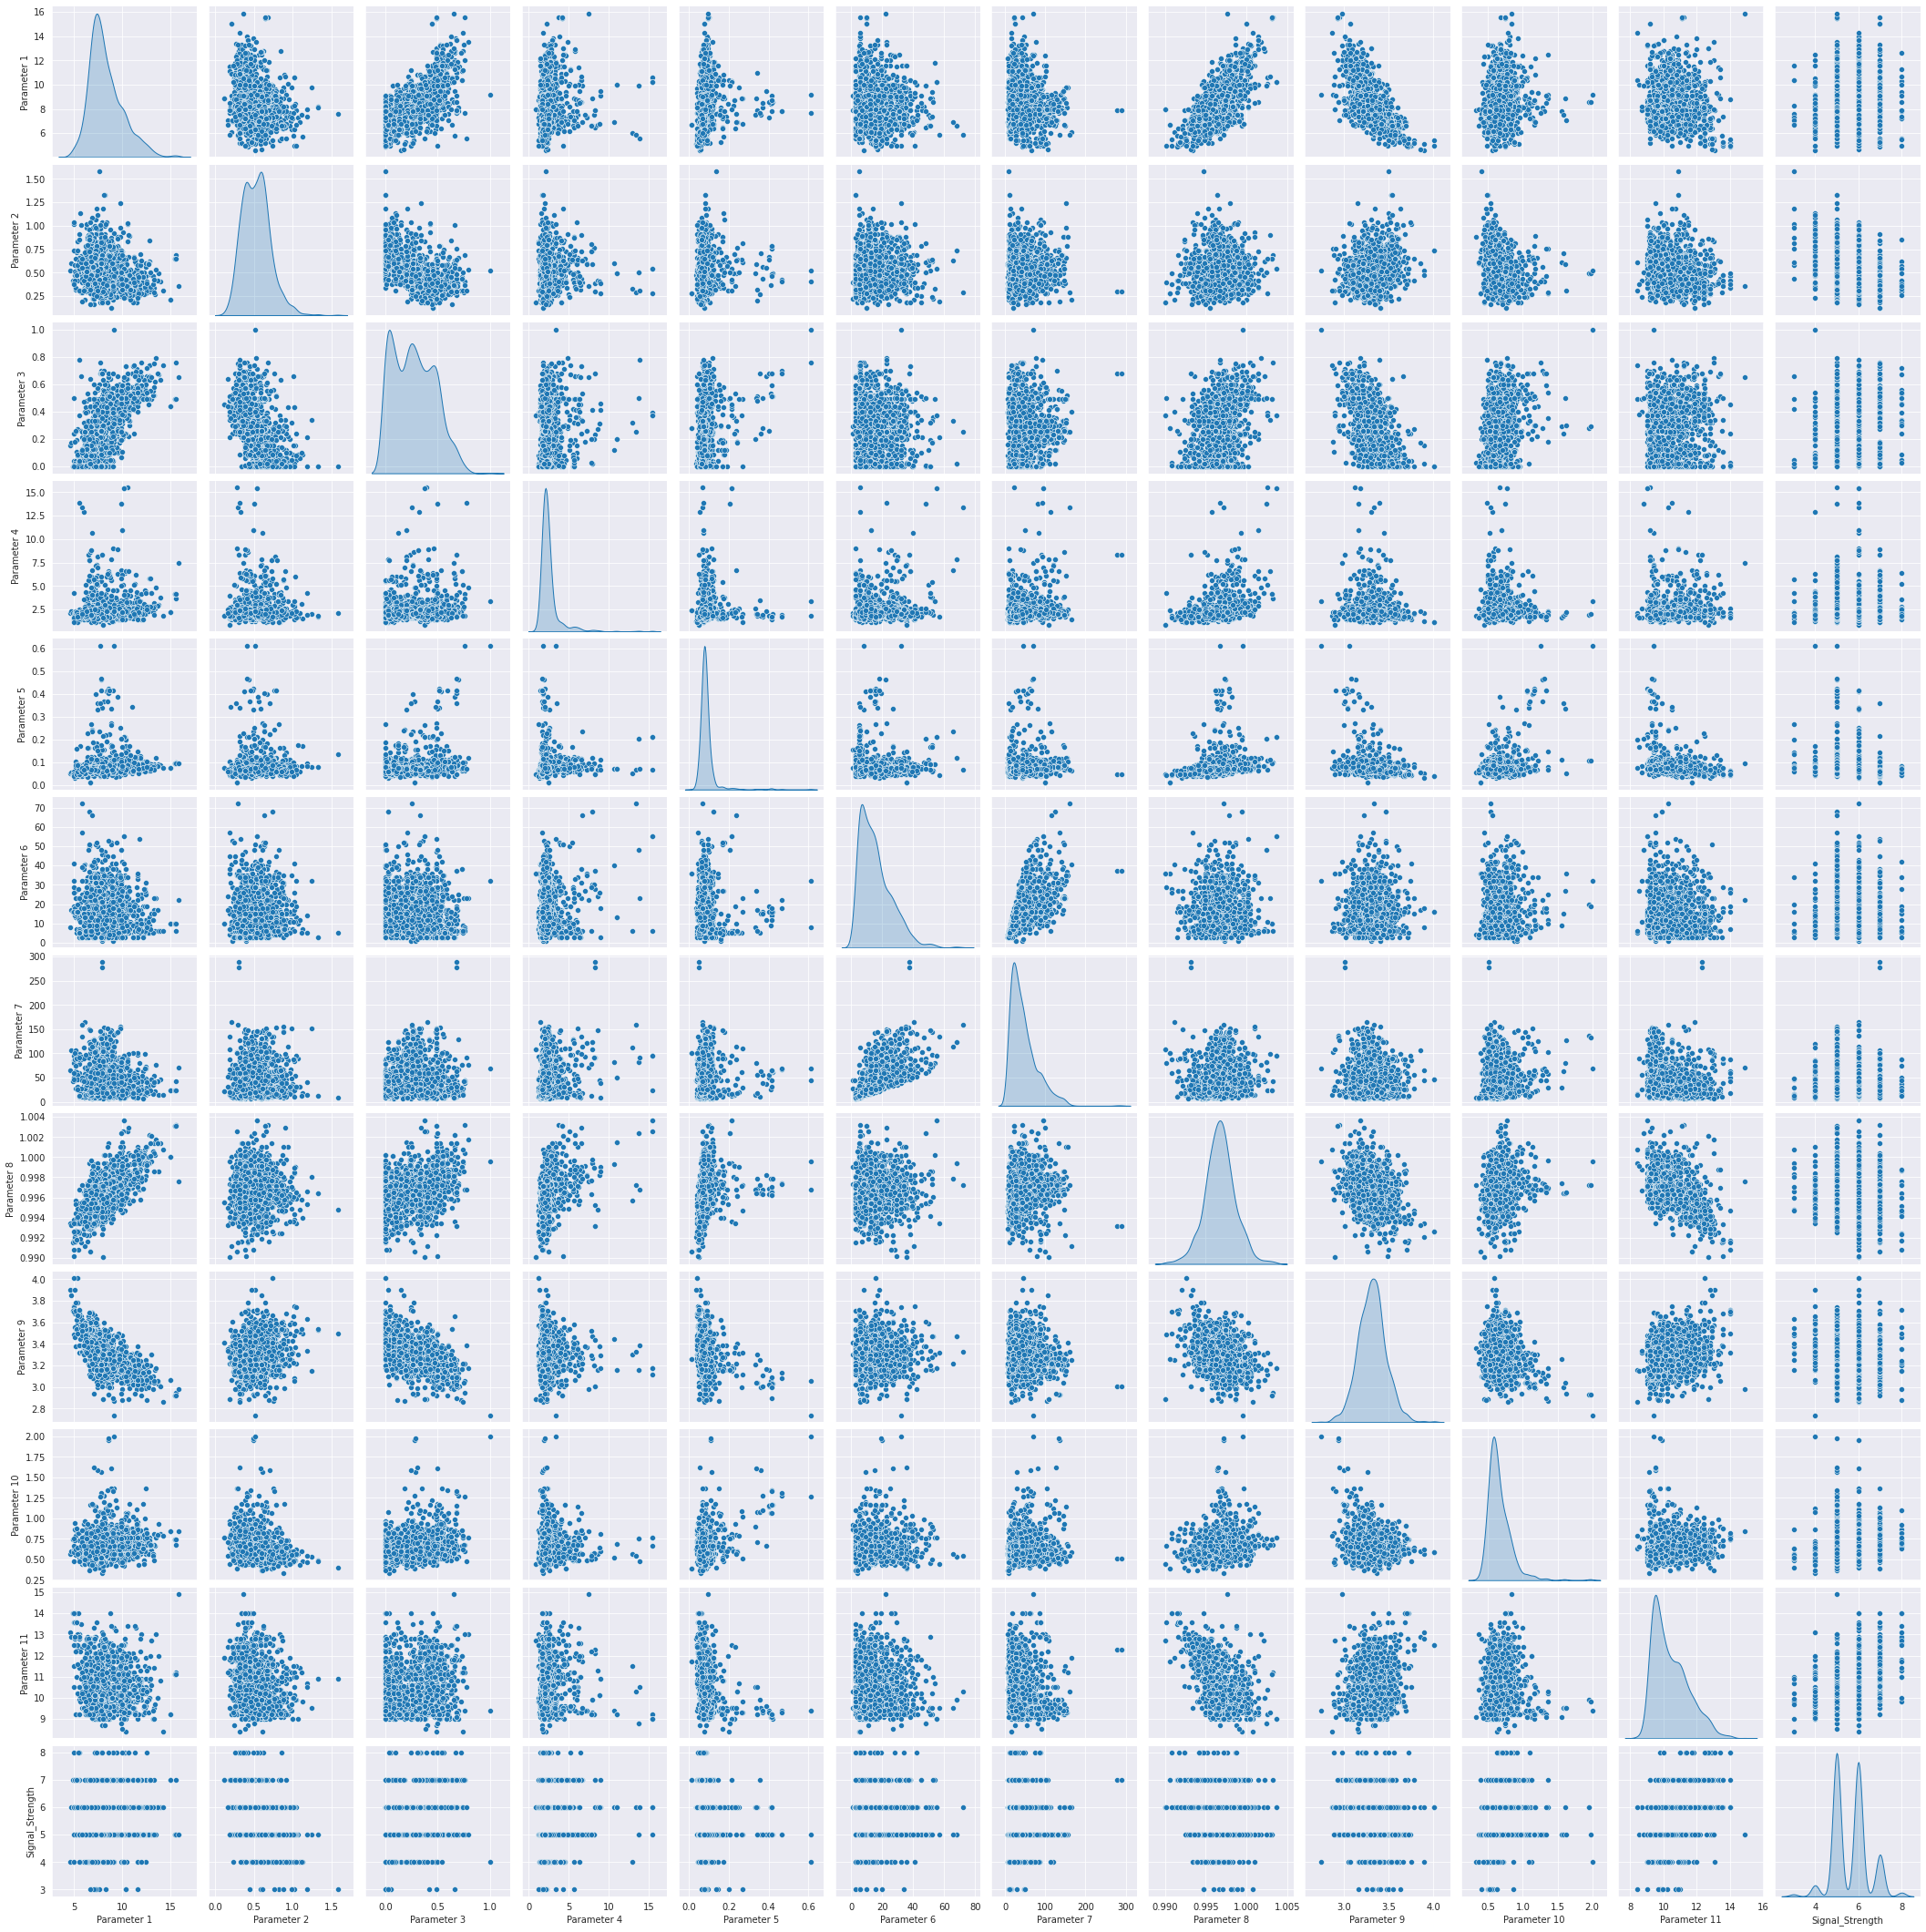

In [11]:
# pairwise scatter plots and the distributions
sns.pairplot(data=signals,diag_kind='kde') 
plt.show()

In [12]:
# finding the correlation matrix
corr = signals.corr()
corr

,Parameter 1,Parameter 2,Parameter 3,Parameter 4,Parameter 5,Parameter 6,Parameter 7,Parameter 8,Parameter 9,Parameter 10,Parameter 11,Signal_Strength
Parameter 1,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
Parameter 2,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
Parameter 3,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
Parameter 4,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
Parameter 5,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
Parameter 6,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
Parameter 7,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
Parameter 8,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
Parameter 9,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
Parameter 10,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


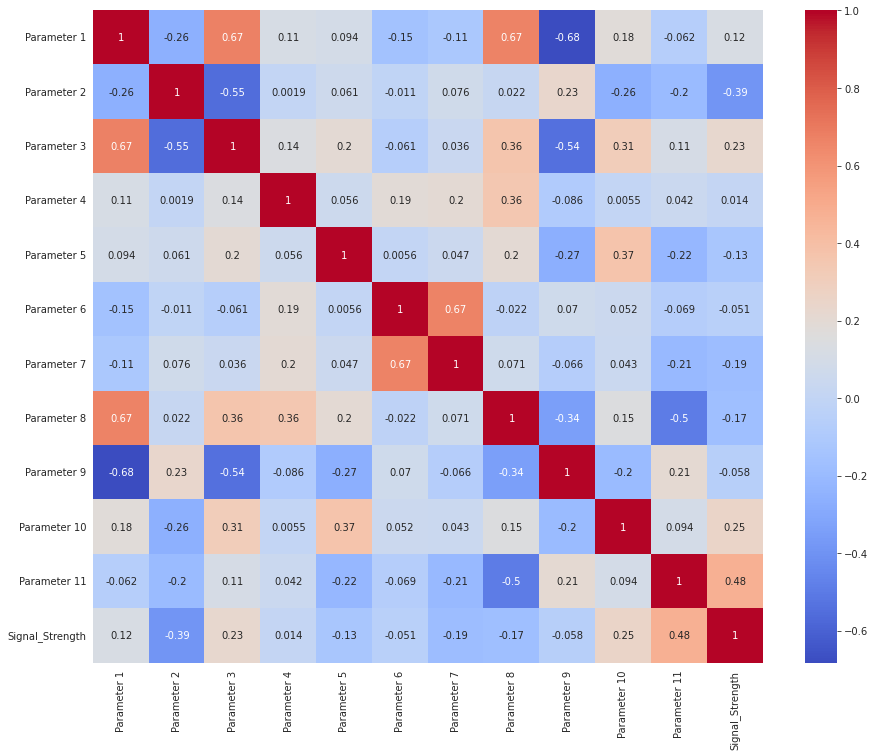

In [13]:
# visualisation of correlation matrix
plt.figure(figsize=(15,12))
sns.heatmap(corr, annot=True,cmap='coolwarm')
plt.show()

### Observations:
- From the `pairplot` or `correlation matrix` or the `heatmap` we can see there is **negative correlation** in some features like `Parameter 1`, `Parameter 8`, `Parameter 2` and **positive correlation** in some features like `Parameter 1`, `Parameter 3`, `Parameter 8`, `Parameter 7`, `Parameter 6`.
- Imputing values in `outlier_columns` by bringing values lower than `lower_fence` upto `lower_fence` and values higher than `upper_fence` upto `upper_fence`.
- I chose this approach of correcting outliers rather than imputimg to `mean`, `median` or `zero`, because those would change concentration of data and also outliers are more similar to the boundary elements.
- Actually we should ask a domain expert about the valid acceptable range of values

In [14]:
def pull_outliers_to_quartile_limits(df,outlier_cols):
  '''
  This function is used to pull the outliers to the extreme fences.
  '''
  for col_name in outlier_cols:
    lower_fence,upper_fence = calculateLowerAndUpperFence(df,col_name)
    print(f'The number of outliers for {col_name} before imputing are {number_of_outliers(df,col_name,lower_fence,upper_fence)}')

    col_index = df.columns.get_loc(col_name)
    # imputing values lower than lower fence equal to lower fence
    for row_index in np.where(df[col_name] < lower_fence)[0]:
        df.iloc[[row_index],[col_index]] = lower_fence

    # imputing values higher than upper fence equal to upper fence
    for row_index in np.where(df[col_name] > upper_fence)[0]:
        df.iloc[[row_index],[col_index]] = upper_fence
    
    print(f'The number of outliers for {col_name} after imputing are {number_of_outliers(df,col_name,lower_fence,upper_fence)}')
    print()

In [15]:
# copying the dataset before any manipulation, to preserve original
signals_copy = signals.copy()

In [16]:
pull_outliers_to_quartile_limits(signals_copy,outlier_cols)  # call to appropriate function

The number of outliers for Parameter 1 before imputing are 49
The number of outliers for Parameter 1 after imputing are 0

The number of outliers for Parameter 2 before imputing are 19
The number of outliers for Parameter 2 after imputing are 0

The number of outliers for Parameter 3 before imputing are 1
The number of outliers for Parameter 3 after imputing are 0

The number of outliers for Parameter 4 before imputing are 155
The number of outliers for Parameter 4 after imputing are 0

The number of outliers for Parameter 5 before imputing are 112
The number of outliers for Parameter 5 after imputing are 0

The number of outliers for Parameter 6 before imputing are 30
The number of outliers for Parameter 6 after imputing are 0

The number of outliers for Parameter 7 before imputing are 55
The number of outliers for Parameter 7 after imputing are 0

The number of outliers for Parameter 8 before imputing are 45
The number of outliers for Parameter 8 after imputing are 0

The number of o

## Deep Neural Network Regressor

In [17]:
# segregating into predictor vs target features
X = np.array(signals.drop(columns=['Signal_Strength'],axis=1)) # predictor features
y = np.array(signals['Signal_Strength']) # target feature

In [18]:
# splitting data into train:test as 90:10
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.10,random_state=seed)

In [19]:
# initialising a Sequential model
model_reg = tf.keras.models.Sequential()

In [20]:
# first hidden layer
model_reg.add(tf.keras.layers.BatchNormalization(input_shape=(11,))) # batch normalization before the hidden layer
model_reg.add(tf.keras.layers.Dense(units=200)) # 200 neuron layer
model_reg.add(tf.keras.layers.LeakyReLU(alpha=0.01)) # adding a Leaky ReLU activation

In [21]:
# second hidden layer
model_reg.add(tf.keras.layers.BatchNormalization()) # batch normalization before the hidden layer
model_reg.add(tf.keras.layers.Dense(units=100)) # 100 neuron layer
model_reg.add(tf.keras.layers.LeakyReLU(alpha=0.01)) # adding a Leaky ReLU activation

In [22]:
# third hidden layer
model_reg.add(tf.keras.layers.BatchNormalization()) # batch normalization before the hidden layer
model_reg.add(tf.keras.layers.Dense(units=60)) # 60 neuron layer
model_reg.add(tf.keras.layers.LeakyReLU(alpha=0.01)) # adding a Leaky ReLU activation

In [23]:
# fourth hidden layer
model_reg.add(tf.keras.layers.BatchNormalization()) # batch normalization before the hidden layer
model_reg.add(tf.keras.layers.Dense(units=30)) # 30 neuron layer
model_reg.add(tf.keras.layers.LeakyReLU(alpha=0.01)) # adding a Leaky ReLU activation

In [24]:
# output layer
model_reg.add(tf.keras.layers.BatchNormalization()) # batch normalization before the output layer
model_reg.add(tf.keras.layers.Dense(units=1)) # predicted output

In [25]:
# compiling a 4-hidden layer deep neural network
# with an Adam optimizer, 
# loss calculated on mean ansolute error because of outliers
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model_reg.compile(optimizer=adam_optimizer, loss='mean_absolute_error')

In [26]:
# describing the model summary
model_reg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 11)               44        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 200)               2400      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 200)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0

In [27]:
# a model checkpoint to hold only the lowest loss model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_reg.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

In [28]:
# fit model for 400 epochs with batch size 10
# that means in each iteration data would be supplied to the model in size of 10, and total of
# train_size/10 times.
regressor_training_history = model_reg.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=400,
          batch_size=10,
          callbacks = [model_checkpoint])

Epoch 1/400
139/144 [===========================>..] - ETA: 0s - loss: 1.4702
Epoch 00001: val_loss improved from inf to 0.52758, saving model to model_reg.h5
144/144 [==============================] - 6s 12ms/step - loss: 1.4424 - val_loss: 0.5276
Epoch 2/400
144/144 [==============================] - ETA: 0s - loss: 0.6269
Epoch 00002: val_loss did not improve from 0.52758
144/144 [==============================] - 1s 10ms/step - loss: 0.6269 - val_loss: 0.6716
Epoch 3/400
142/144 [============================>.] - ETA: 0s - loss: 0.5930
Epoch 00003: val_loss improved from 0.52758 to 0.47738, saving model to model_reg.h5
144/144 [==============================] - 1s 10ms/step - loss: 0.5915 - val_loss: 0.4774
Epoch 4/400
139/144 [===========================>..] - ETA: 0s - loss: 0.5629
Epoch 00004: val_loss did not improve from 0.47738
144/144 [==============================] - 1s 10ms/step - loss: 0.5655 - val_loss: 0.5366
Epoch 5/400
139/144 [===========================>..] - ETA: 

In [29]:
# load best saved model
loaded_regressor = tf.keras.models.load_model('model_reg.h5')
# summarize model
loaded_regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 11)               44        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 200)               2400      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 200)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0

In [30]:
# evaluating the loaded classifier on train data
train_metrics = loaded_regressor.evaluate(X_train,y_train,verbose=0)

In [31]:
# evaluating the loaded classifier on test data
test_metrics = loaded_regressor.evaluate(X_test,y_test,verbose=0)

In [34]:
# displaying the evaluated metrics
metrics_df = pd.DataFrame(index=['Loss'],columns=['Training','Testing'],
                          data=[[train_metrics,test_metrics]])
metrics_df

,Training,Testing
Loss,0.38339,0.356468


In [35]:
def plot_train_val_loss_with_epochs(training_history):
  '''
  This function is used to plot Training and Validation loss
  versus the number of epochs based on the training history of the model.
  '''
  # extracting training and validation losses from model history
  train_loss = training_history.history['loss']
  val_loss = training_history.history['val_loss']
  
  # number of epochs
  epochs = range(len(train_loss))

  # plot train and validation loss w.r.t number of epochs
  plt.figure(figsize=(10,8))
  plt.plot(epochs, train_loss, label = 'training loss')
  plt.plot(epochs, val_loss, label = 'validation loss')
  plt.legend(loc='upper right')
  plt.xlabel('Number of Epochs')
  plt.ylabel('Training and Validation loss')
  plt.title('Training and Validation loss v/s Epochs')
  plt.show()

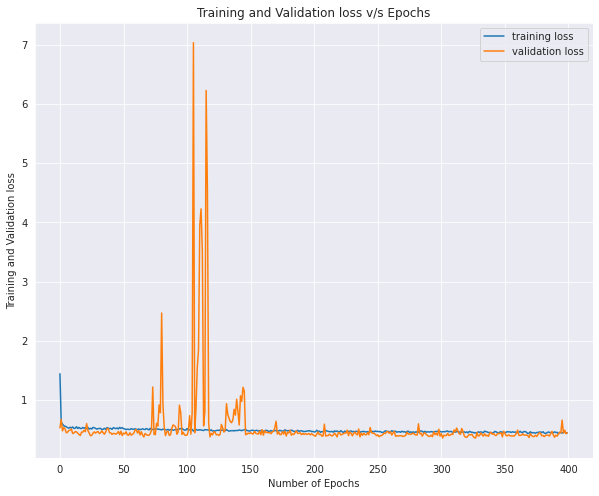

In [36]:
# call to appropriate function
plot_train_val_loss_with_epochs(regressor_training_history)

In [45]:
# Making predictions with the test target
for i in range(10):
  rand_idx = np.random.randint(low=0,high=X_test.shape[0])
  pred = loaded_regressor.predict(np.expand_dims(X_test[rand_idx],axis=0))
  print(f'Predicted Value is {pred[0][0]}')
  print(f'Actual Label is {y_test[rand_idx]}')
  print()

Predicted Value is 5.919991493225098
Actual Label is 6

Predicted Value is 5.989562034606934
Actual Label is 6

Predicted Value is 5.1055779457092285
Actual Label is 6

Predicted Value is 5.995081424713135
Actual Label is 6

Predicted Value is 5.051499366760254
Actual Label is 6

Predicted Value is 5.989562034606934
Actual Label is 6

Predicted Value is 6.012506008148193
Actual Label is 7

Predicted Value is 5.688885688781738
Actual Label is 6

Predicted Value is 5.046856880187988
Actual Label is 6

Predicted Value is 4.963399887084961
Actual Label is 5



### Observations:
- The training loss is **38%**.
- The testing loss is **35%**.
- The predicted values are very close to the actual values.

# Part two - Project Based - Neural Network Classifier

**DOMAIN**: Autonomous Vehicles

**BUSINESS CONTEXT**: A Recognising multi-digit numbers in photographs captured at street level is an important component of modern-day map making. A classic example of a corpus of such street-level photographs is **Google’s Street View** imagery composed of hundreds of millions of geo-located 360-degree panoramic images.
The ability to automatically transcribe an address number from a geo-located
patch of pixels and associate the transcribed number with a known street address helps pinpoint, with a high degree of accuracy, the location of the building it represents. More broadly, recognising numbers in photographs is a problem of interest to the optical character recognition community.
While `OCR` on constrained domains like document processing is well studied arbitrary multi-character text recognition in photographs is still highly challenging. This difficulty arises due to the wide variability in the visual appearance of text in the wild on account of a large range of fonts, colours, styles, orientations, and character arrangements. 
The recognition problem is further complicated by environmental factors such as lighting, shadows, specularity, and occlusions as well as by image acquisition factors such as resolution, motion, and focus blurs. In this project, we will use the dataset with images centred around a single digit (many of the images do contain some distractors at the sides). Although we are taking a sample of the data which is simpler, it is more complex than MNIST because of the distractors.

**DATA DESCRIPTION**: The `SVHN` is a real-world image dataset for developing machine learning and object recognition algorithms with the minimal requirement on data formatting but comes from a significantly harder, unsolved, real-world problem (recognising digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

## Import necessary libraries

In [46]:
# almost all the necessary libraries are loaded into the session from above

# reading h5 files
import h5py

## Import the Data

In [47]:
# reading h5py file in read only mode
svhn = h5py.File('/content/drive/MyDrive/Colab Notebooks/Part - 4 - Autonomous_Vehicles_SVHN_single_grey1.h5','r')

In [48]:
# seeing keys of data
svhn.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

In [49]:
# Load the training data
X_train = svhn['X_train'][:]
y_train = svhn['y_train'][:]

In [50]:
# Load the validation data
X_val = svhn['X_val'][:]
y_val = svhn['y_val'][:]

In [51]:
# Load the test data
X_test = svhn['X_test'][:]
y_test = svhn['y_test'][:]

## Data Analysis and Visualisation

In [52]:
# shape of training predictors
X_train.shape

(42000, 32, 32)

In [53]:
# shape of training labels
y_train.shape

(42000,)

In [54]:
# shape of validation predictors
X_val.shape

(60000, 32, 32)

In [55]:
# shape of validation labels
y_val.shape

(60000,)

In [56]:
# shape of test predictors
X_test.shape

(18000, 32, 32)

In [57]:
# shape of test labels
y_test.shape

(18000,)

In [58]:
# checking few train records
X_train[0:2]

array([[[ 33.0704,  30.2601,  26.852 , ...,  71.4471,  58.2204,
          42.9939],
        [ 25.2283,  25.5533,  29.9765, ..., 113.0209, 103.3639,
          84.2949],
        [ 26.2775,  22.6137,  40.4763, ..., 113.3028, 121.775 ,
         115.4228],
        ...,
        [ 28.5502,  36.212 ,  45.0801, ...,  24.1359,  25.0927,
          26.0603],
        [ 38.4352,  26.4733,  23.2717, ...,  28.1094,  29.4683,
          30.0661],
        [ 50.2984,  26.0773,  24.0389, ...,  49.6682,  50.853 ,
          53.0377]],

       [[ 86.9591,  87.0685,  88.3735, ...,  91.8014,  89.7477,
          92.5302],
        [ 86.688 ,  86.9114,  87.4337, ...,  90.7306,  87.204 ,
          88.5629],
        [ 85.9654,  85.8145,  85.9239, ...,  63.8626,  59.8199,
          54.8805],
        ...,
        [ 90.2236,  91.0448,  93.4637, ...,  55.3535,  48.5822,
          44.0557],
        [ 90.6427,  90.4039,  90.937 , ...,  78.2696,  77.4977,
          74.27  ],
        [ 88.0236,  88.1977,  86.6709, ...,  75.

In [59]:
# checking few train labels
y_train[0:2]

array([2, 6], dtype=uint8)

In [60]:
# checking the minimum value
X_train.min()

0.0

In [61]:
# checking the maximum value
X_train.max()

254.9745

In [62]:
# checking number of unique labels
tf.unique(y_train)

Unique(y=<tf.Tensor: shape=(10,), dtype=uint8, numpy=array([2, 6, 7, 4, 0, 3, 1, 8, 5, 9], dtype=uint8)>, idx=<tf.Tensor: shape=(42000,), dtype=int32, numpy=array([0, 1, 2, ..., 2, 4, 3], dtype=int32)>)

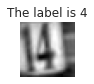


**********


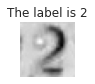


**********


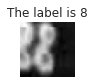


**********


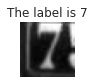


**********


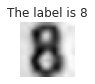


**********


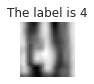


**********


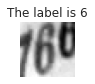


**********


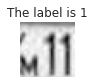


**********


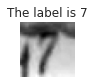


**********


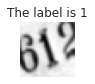


**********


In [63]:
# visualising few train images and corresponding labels
for i in range(10):
  plt.figure(figsize=(1, 1))
  rand_idx = np.random.randint(low=0,high=X_train.shape[0])
  plt.title(f'The label is {y_train[rand_idx]}')
  plt.imshow(X_train[rand_idx],cmap='gray')
  plt.axis('off')
  plt.show()
  print()
  print('*'*10)

In [64]:
# initialising label dataframes
train_label_df = pd.DataFrame(columns=['Train Labels'], data=y_train)
val_label_df = pd.DataFrame(columns=['Validation Labels'], data=y_val)
test_label_df = pd.DataFrame(columns=['Test Labels'], data=y_test)

In [65]:
def pie_chart_and_count_plot(df,col_name):
  '''
  This function plots the pie-chart and count-plot for the target labels.
  '''
  # initialising subplots
  figure, ax = plt.subplots(nrows=1, ncols=2)

  # setting figure parameters
  figure.set_figheight(7)
  figure.set_figwidth(15)

  #setting axes titles
  ax[0].set_title(f'Pie Chart of {col_name.upper()}')
  ax[1].set_title(f'Count plot of {col_name.upper()}')

  # plotting the distribution
  df[col_name].value_counts().plot.pie(ax=ax[0],autopct='%1.1f%%')
  sns.countplot(x=col_name,data=df,ax=ax[1])

  plt.show()

Values for TRAIN LABELS
3    4281
5    4232
2    4197
9    4196
7    4192
8    4188
4    4188
0    4186
1    4172
6    4168
Name: Train Labels, dtype: int64



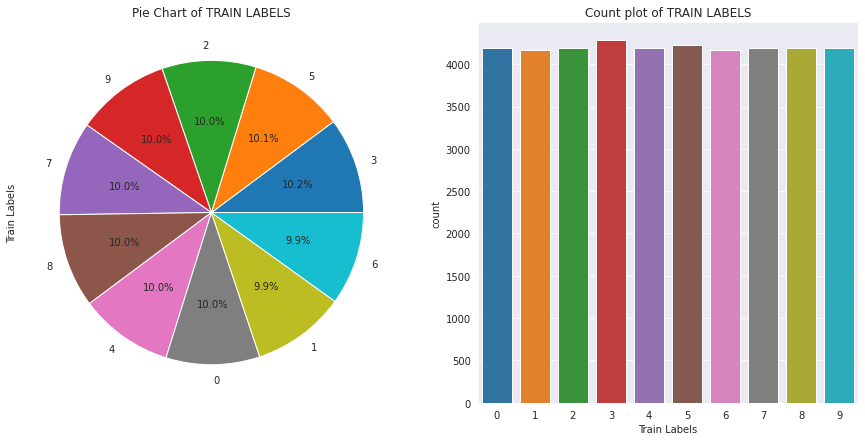

****************************************
Values for VALIDATION LABELS
9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: Validation Labels, dtype: int64



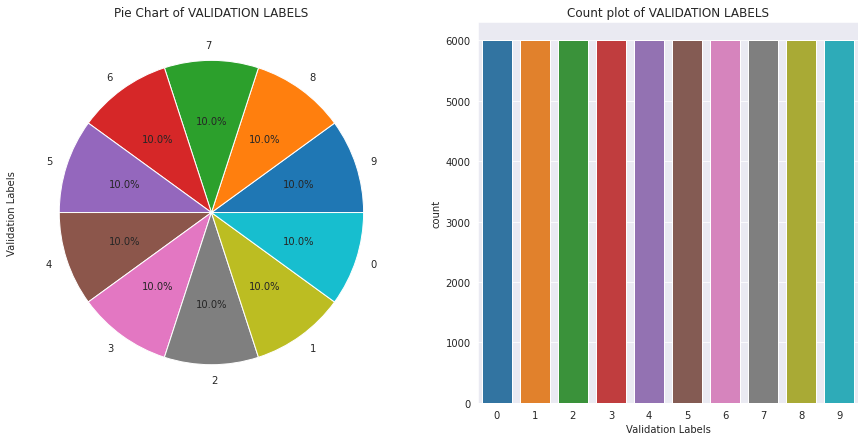

****************************************
Values for TEST LABELS
6    1832
1    1828
0    1814
8    1812
4    1812
7    1808
9    1804
2    1803
5    1768
3    1719
Name: Test Labels, dtype: int64



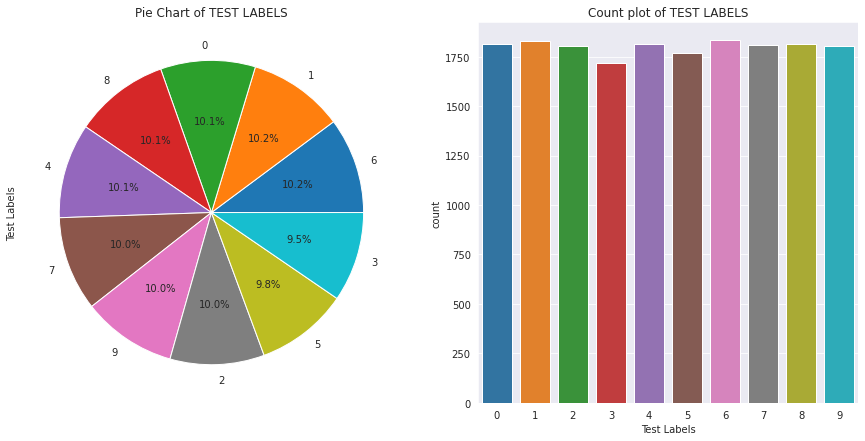

****************************************


In [66]:
# seeing various values for target labels
for df in train_label_df,val_label_df,test_label_df:
  for col in df.columns:
    print(f'Values for {col.upper()}')
    print(df[col].value_counts())
    print()
    pie_chart_and_count_plot(df,col) # call to plotting function
    print('*'*40)

### Observations:
- **Training Set**:
  + There are **42000** train images each with **32x32** size each with corresponding labels.
- **Validation Set**:
  + There are **60000** train images each with **32x32** size each with corresponding labels.
- **Testing Set**:
  + There are **18000** train images each with **32x32** size each with corresponding labels.
- The **32x32** would needed to be *re-shaped* to an array of **1024** size.
- As the `min` and `max` value of pixels have a varied range of **0-255**, they would need to be **normalized**.
- As there are **10** *unique* labels and we are building a *classifier*, we would need to **one-hot encode** the labels to 10 classes.
- The number of labels for each value in each of the datasets seems **well-balanced**, so there is no need of *up-sampling* or *down-sampling*.

## Building a Deep Neural Network Classifier

In [67]:
# one-hot encode the labels
y_train_enc = tf.keras.utils.to_categorical(y_train,num_classes=10)
y_val_enc = tf.keras.utils.to_categorical(y_val,num_classes=10)
y_test_enc = tf.keras.utils.to_categorical(y_test,num_classes=10)

In [68]:
# checking few encoded labels
y_train_enc[0:2]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [69]:
# initialising the classifier
classifier = tf.keras.models.Sequential()

# adding the Re-Shaped input layer
classifier.add(tf.keras.layers.Reshape(target_shape=(1024,),input_shape=(32,32,)))

In [70]:
# first hidden layer
classifier.add(tf.keras.layers.BatchNormalization()) # batch normalization before the hidden layer
classifier.add(tf.keras.layers.Dense(units=200)) # 200 neuron layer
classifier.add(tf.keras.layers.LeakyReLU(alpha=0.01)) # adding a Leaky ReLU activation

In [71]:
# second hidden layer
classifier.add(tf.keras.layers.BatchNormalization()) # batch normalization before the hidden layer
classifier.add(tf.keras.layers.Dense(units=100)) # 100 neuron layer
classifier.add(tf.keras.layers.LeakyReLU(alpha=0.01)) # adding a Leaky ReLU activation

In [72]:
# third hidden layer
classifier.add(tf.keras.layers.BatchNormalization()) # batch normalization before the hidden layer
classifier.add(tf.keras.layers.Dense(units=60)) # 60 neuron layer
classifier.add(tf.keras.layers.LeakyReLU(alpha=0.01)) # adding a Leaky ReLU activation

In [73]:
# fourth hidden layer
classifier.add(tf.keras.layers.BatchNormalization()) # batch normalization before the hidden layer
classifier.add(tf.keras.layers.Dense(units=30)) # 30 neuron layer
classifier.add(tf.keras.layers.LeakyReLU(alpha=0.01)) # adding a Leaky ReLU activation

In [74]:
# output layer
classifier.add(tf.keras.layers.BatchNormalization()) # batch normalization before the output layer
classifier.add(tf.keras.layers.Dense(units=10,activation='softmax')) # predicted output with softmax activation to get probability

In [75]:
# compiling a 4-hidden layer deep neural network classifier
# with an Adam optimizer, 
# loss calculated on categorical_cross_entropy,
# evaluated on accuracy metric
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [76]:
# describing the classifier
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1024)              0         
                                                                 
 batch_normalization_5 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 200)               205000    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 200)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 100)              

In [77]:
# a model checkpoint to hold only the best accuracy model with architecture and weights
classifier_checkpoint = tf.keras.callbacks.ModelCheckpoint('classifier.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [78]:
# fit model for 200 epochs with batch size 32
# that means in each iteration data would be supplied to the model in size of 32, and total of
# train_size/32 times.
classifier_training_history = classifier.fit(X_train,y_train_enc,
          validation_data=(X_val,y_val_enc),
          epochs=200,
          batch_size=32,
          callbacks = [classifier_checkpoint])

Epoch 1/200
1313/1313 [==============================] - ETA: 0s - loss: 1.5734 - accuracy: 0.4729
Epoch 00001: val_accuracy improved from -inf to 0.65367, saving model to classifier.h5
1313/1313 [==============================] - 19s 13ms/step - loss: 1.5734 - accuracy: 0.4729 - val_loss: 1.0962 - val_accuracy: 0.6537
Epoch 2/200
1308/1313 [============================>.] - ETA: 0s - loss: 1.1359 - accuracy: 0.6383
Epoch 00002: val_accuracy improved from 0.65367 to 0.73532, saving model to classifier.h5
1313/1313 [==============================] - 16s 12ms/step - loss: 1.1351 - accuracy: 0.6387 - val_loss: 0.8514 - val_accuracy: 0.7353
Epoch 3/200
1312/1313 [============================>.] - ETA: 0s - loss: 0.9896 - accuracy: 0.6845
Epoch 00003: val_accuracy improved from 0.73532 to 0.76800, saving model to classifier.h5
1313/1313 [==============================] - 17s 13ms/step - loss: 0.9899 - accuracy: 0.6844 - val_loss: 0.7535 - val_accuracy: 0.7680
Epoch 4/200
1310/1313 [========

In [79]:
# load best saved model
loaded_classifier = tf.keras.models.load_model('classifier.h5')
# summarize model
loaded_classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1024)              0         
                                                                 
 batch_normalization_5 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 200)               205000    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 200)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 100)              

In [80]:
# evaluating the loaded classifier on train data
train_metrics = loaded_classifier.evaluate(X_train,y_train_enc,verbose=0)

In [81]:
# evaluating the loaded classifier on test data
val_metrics = loaded_classifier.evaluate(X_val,y_val_enc,verbose=0)

In [82]:
# evaluating the loaded classifier on test data
test_metrics = loaded_classifier.evaluate(X_test,y_test_enc,verbose=0)

In [83]:
# displaying the evaluated metrics
metrics_df = pd.DataFrame(index=['Loss','Accuracy'],columns=['Training','Validation','Testing'],
                          data=[[train_metrics[0],val_metrics[0],test_metrics[0]],[train_metrics[1],val_metrics[1],test_metrics[1]]])
metrics_df

,Training,Validation,Testing
Loss,0.100169,0.212681,0.475210
Accuracy,0.972643,0.942633,0.872611


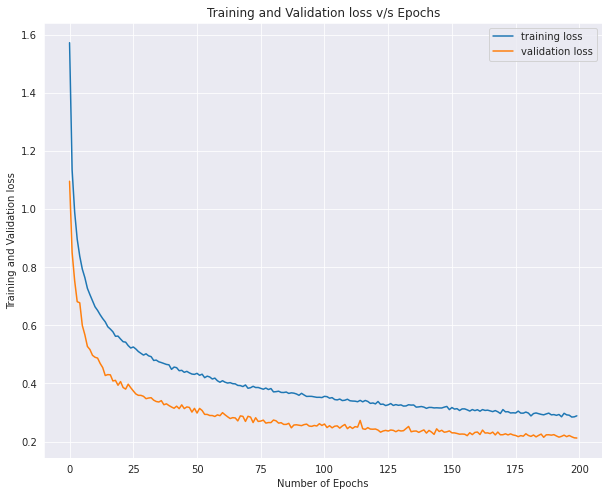

In [84]:
# call to appropriate function
plot_train_val_loss_with_epochs(classifier_training_history)

In [85]:
# extracting training and validation accuracies and losses from model history
classifier_train_accuracy = classifier_training_history.history['accuracy']
classifier_val_accuracy = classifier_training_history.history['val_accuracy']

# number of epochs
epochs = range(len(classifier_train_accuracy))

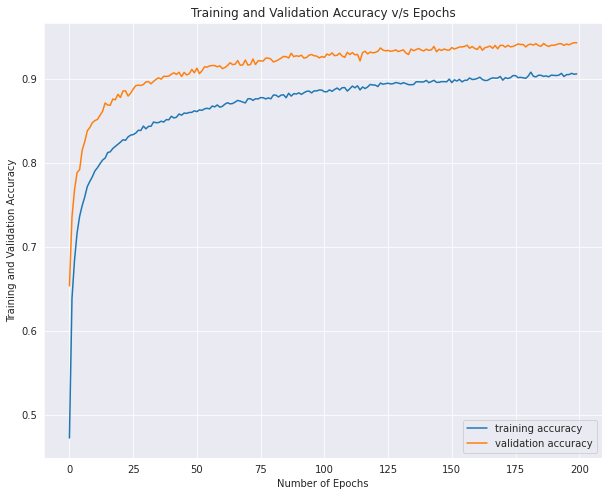

In [86]:
# plot train and validation accuracy w.r.t number of epochs
plt.figure(figsize=(10,8))
plt.plot(epochs, classifier_train_accuracy, label = 'training accuracy')
plt.plot(epochs, classifier_val_accuracy, label = 'validation accuracy')
plt.legend(loc='lower right')
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Accuracy')
plt.title('Training and Validation Accuracy v/s Epochs')
plt.show()

### Observations:
After training the 4-hidden layer deep neural network with *batch-normalization*, *dense* layers using `leaky-ReLU` activations and *Adam* optimizer for *200 epochs*:
- The training loss and accuracy are **10.21%** and **97.25%** respectively.
- The validation loss and accuracy are **21.57%** and **94.27%** respectively.
- The testing loss and accuracy are **48.12%** and **87.14%** respectively.
- The *learning-rate* is good as the loss dropped steadily for start iterations and kept on reducing gradually.

Predicted Label is 7
Actual Label is 0


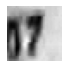


**********
Predicted Label is 1
Actual Label is 1


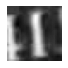


**********
Predicted Label is 0
Actual Label is 0


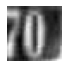


**********
Predicted Label is 2
Actual Label is 2


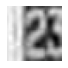


**********
Predicted Label is 2
Actual Label is 2


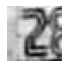


**********
Predicted Label is 8
Actual Label is 8


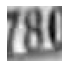


**********
Predicted Label is 8
Actual Label is 8


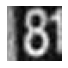


**********
Predicted Label is 7
Actual Label is 7


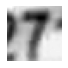


**********
Predicted Label is 2
Actual Label is 2


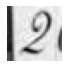


**********
Predicted Label is 9
Actual Label is 0


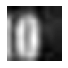


**********


In [87]:
# Making predictions and visualising the test labels for few test images
for i in range(10):
  plt.figure(figsize=(1, 1))
  rand_idx = np.random.randint(low=0,high=X_test.shape[0])
  X_test_exp = np.expand_dims(X_test[rand_idx],axis=0)
  pred = loaded_classifier.predict(X_test_exp)
  print(f'Predicted Label is {np.argmax(pred)}')
  print(f'Actual Label is {y_test[rand_idx]}')
  plt.imshow(X_test[rand_idx],cmap='gray')
  plt.axis('off')
  plt.show()
  print()
  print('*'*10)

I have tried to incorporate majority of the concepts learned. I tried all activation functions and also changed learning rates and momentum and felt this was the best approach.